# Capstone Project - The Battle of Neighborhoods (Week 1-2)

## Introduction

### Background

London is considered to be one of the world's most important global cities and has been called the world's most powerful, most desirable, most influential, most visited, most expensive, innovative, sustainable, most investment-friendly, and most-popular-for-work city.

London attract lots of new inhabitants, new investors each year because above reasons.

### Problem

London is a huge city, not everyone knows London well before they go there. It is risky to move to a place you barely known.

This report addressed this problem and provide a investment guide to people who want to open a restaurant in London. 

It supposed to help those new commers to have a general business view of London. So, they can better decide where they are going.

### Assumptions

Usually businesses are grouped together, people like to go to a place with multiple restaurants to have a wider range of choice. If you want to open a restaurant, It is better to go to those places which already have restaurants to minimize the risk. However having same type of restaurants at the same place will be disaster due to competition, We must carefully select correct type of restaurant to increase diversity and decrease competition.

Besides that, richer neighborhoods usually have higher spending power, you would like to setup your business there to maximize the revenue. In this case, It is assumed higher house sales price will indicate higher spending power.

So, this report are based on two assumptions:
1. Multiple but not the same type of restaurants at the same place indicates lesser risk.
2. Higher average house sales price indicates higher revenue.


## Data

To achieve the goal of minimal risk and maximal revenue. I need different sources of data.

- List of boroughs can be obtained on Wikipedia. https://en.wikipedia.org/wiki/List_of_London_boroughs
    - Borough names and geo coordinates can be found here, geo coordinates will be used in foursquare API to find recommended venues.
- By using foursquare API, list of recommended venues can be fetched base on above coordinates. https://api.foursquare.com/v2/venues/explore
    - List of top venues of each borough can be found here to decide the functionality of a borough
- House sale price data on Land registry of UK, I will use data from last two years(2018, 2019 123945 transactions in total). http://prod1.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv
    - District(borough) to house sale price mapping can be extracted here.


In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup

pd.options.display.float_format = "{:.4f}".format


In [2]:
df_data_0 = pd.read_csv('pp_2018_2019.csv', names=['TUID', 'Price', 'Date_Transfer', 'Postcode', 'Prop_Type', 'Old_New', 'Duration', 'PAON', 'SAON', 'Street', 'Locality', 'Town_City', 'District', 'County', 'PPD_Cat_Type', 'Record_Status'])
df_data_0.head()
df_london = df_data_0[df_data_0['County'] == 'GREATER LONDON']
df_london.shape


(207876, 16)

In [3]:
df_london['Price'].median()

455000.0

In [5]:
df_borough_price = df_london.groupby(['District']).mean()
df_borough_price.head()

,Price
District,
BARKING AND DAGENHAM,380133.6469
BARNET,702464.9090
BEXLEY,398162.6044
BRENT,683713.4982
BROMLEY,513846.0275


In [6]:
df_borough_price = df_london.groupby(['District']).median()
df_borough_price.head()

,Price
District,
BARKING AND DAGENHAM,309000.0000
BARNET,500000.0000
BEXLEY,348620.0000
BRENT,470000.0000
BROMLEY,430000.0000


### Have a look at the house price data in London

Seems like there are lots of outliners in the boxplot, therefor median price will be choose to reqresent the average sales price

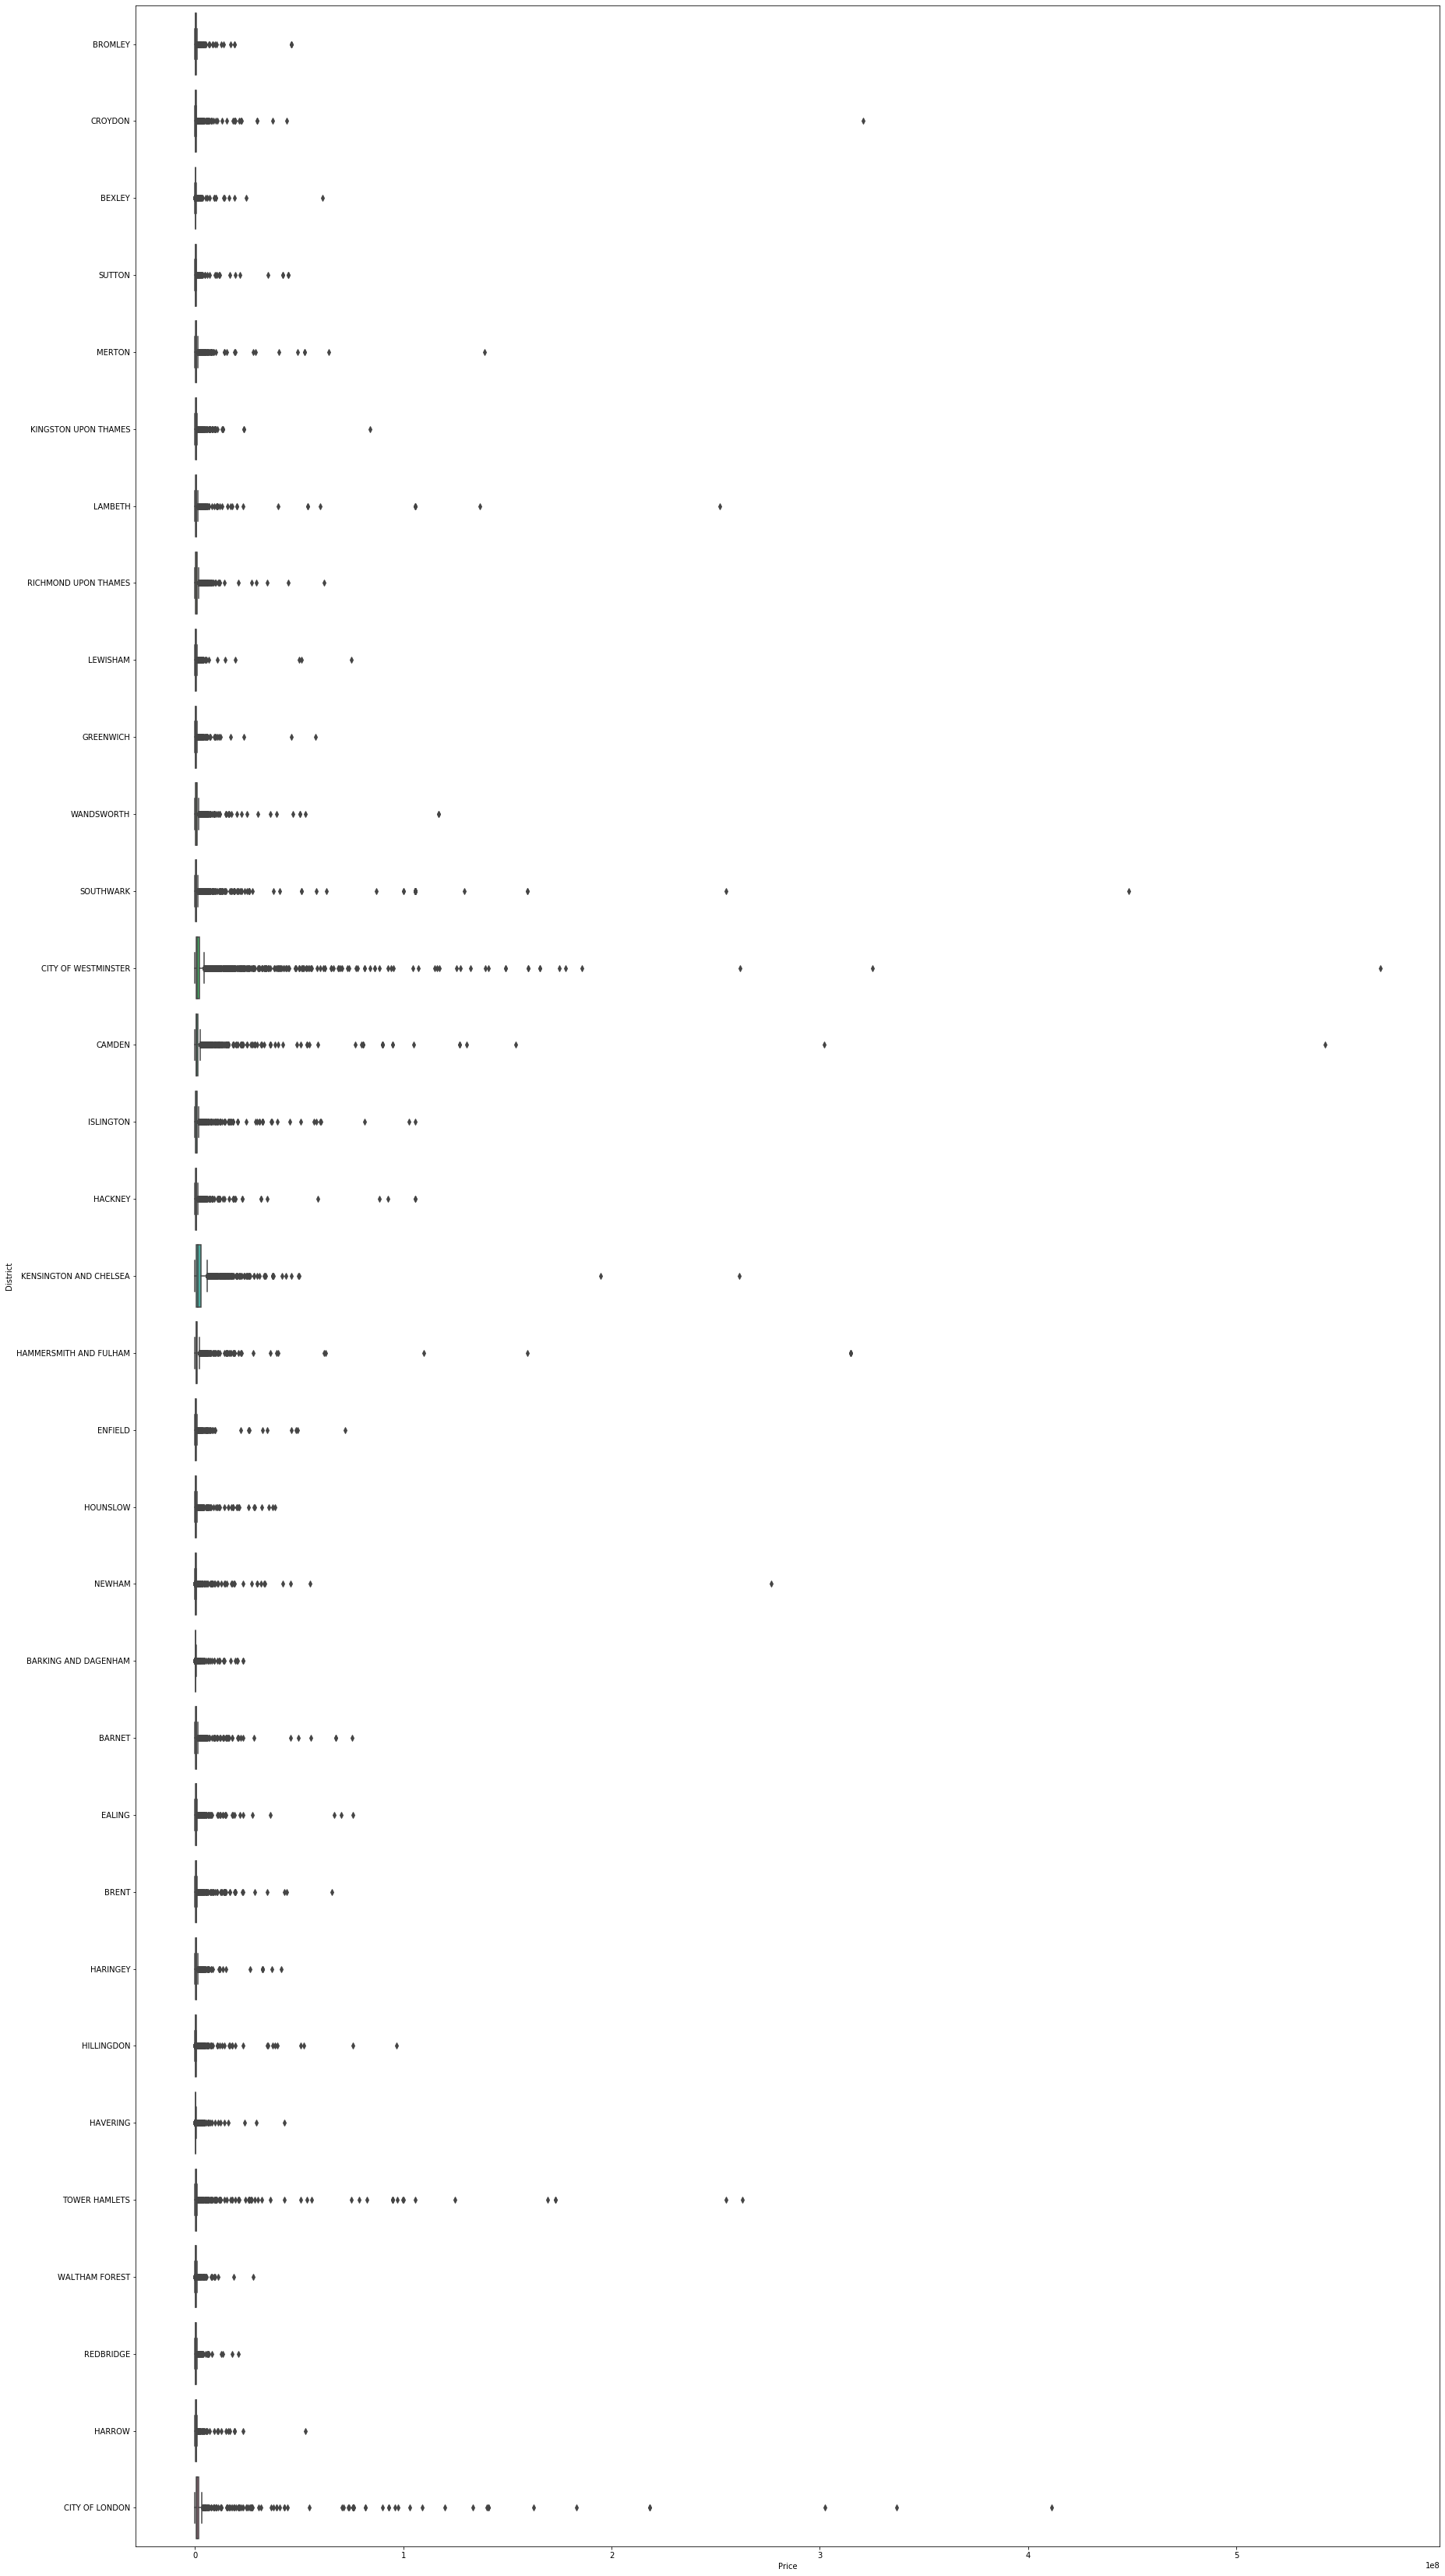

In [7]:
# boxplot = df_london.boxplot(column=['Price'], by='District')
plt.figure(figsize=(30, 60))
sns.boxplot(x="Price", y="District", data=df_london, orient="h")

In [8]:
response_boroughs = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs')

In [9]:
soup_boroughs = BeautifulSoup(response_boroughs.text, 'html.parser')
table_boroughs = soup_boroughs.find_all('table', {'class': 'wikitable'})

data_boroughs = []

for table in table_boroughs:

    for row in table.find_all('tr'):
        
        tds = [td for td in row.find_all('td')]
        if tds:
            name = tds[0].find('a').string.upper()
            geo = tds[8].find('span', {'class': 'geo'}).string.split(';')
            latitude = float(geo[0])
            longitude = float(geo[1])
            data_boroughs.append((name, latitude, longitude))
 

df_boroughs = pd.DataFrame(data_boroughs, columns=['borough', 'latitude', 'longitude'])

# rename westminster to city of westminster to match the data in sales
df_boroughs.loc[31, 'borough'] = 'CITY OF WESTMINSTER'
df_boroughs.head()

,borough,latitude,longitude
0,BARKING AND DAGENHAM,51.5607,0.1557
1,BARNET,51.6252,-0.1517
2,BEXLEY,51.4549,0.1505
3,BRENT,51.5588,-0.2817
4,BROMLEY,51.4039,0.0198


#### Join price data to location data

In [10]:
df_boroughs = df_boroughs.join(df_borough_price, on='borough').rename(columns={'Price': 'price'})
df_boroughs.head()

,borough,latitude,longitude,price
0,BARKING AND DAGENHAM,51.5607,0.1557,309000.0000
1,BARNET,51.6252,-0.1517,500000.0000
2,BEXLEY,51.4549,0.1505,348620.0000
3,BRENT,51.5588,-0.2817,470000.0000
4,BROMLEY,51.4039,0.0198,430000.0000


## Fetch venue data from foursquare

#### Find optimal distiance between boroughs

In [11]:
!pip install geopy

In [11]:
import geopy.distance
import numpy as np

In [12]:
borough_mean_radius_list = []
all_boroughs = df_boroughs['borough'].to_list()

for index1, item1 in df_boroughs.iterrows():   
    all_distance = sorted([geopy.distance.distance((item1['latitude'], item1['longitude']), (item2['latitude'], item2['longitude'])).m for index2, item2 in df_boroughs.iterrows()])
    borough_mean_radius_list.append((all_boroughs[index1], int(np.mean(all_distance[1:4])/2)))

borough_radius = pd.DataFrame(data=borough_mean_radius_list ,columns=['borough','radius'])

borough_radius.head()


,borough,radius
0,BARKING AND DAGENHAM,3039
1,BARNET,3291
2,BEXLEY,4513
3,BRENT,3089
4,BROMLEY,4055


#### Analyze average distance to another borough

In [13]:
df_combined = pd.merge(df_boroughs, borough_radius, how='inner', on=['borough', 'borough'])
df_combined.head()

,borough,latitude,longitude,price,radius
0,BARKING AND DAGENHAM,51.5607,0.1557,309000.0000,3039
1,BARNET,51.6252,-0.1517,500000.0000,3291
2,BEXLEY,51.4549,0.1505,348620.0000,4513
3,BRENT,51.5588,-0.2817,470000.0000,3089
4,BROMLEY,51.4039,0.0198,430000.0000,4055


### Visualize selections

In [17]:
!pip install folium

In [14]:
import folium

In [17]:
london_map = folium.Map(
    location=[51.509865, -0.118092],
    zoom_start=10
)
for index, location in df_combined.iterrows():
    folium.Marker(
        [location['latitude'], location['longitude']], 
        popup=location['borough'], 

    ).add_to(london_map)
    folium.Circle(
        [location['latitude'], location['longitude']], 
        popup=location['borough'], 
        radius=location['radius']

    ).add_to(london_map)


london_map

### Fetch venue data

In [18]:
# @hidden_cell
CLIENT_ID = 'J1JVHYT054FYK125LDRYSJGY21WREMQ1YPMOWHXVOWYQRZZG' 
CLIENT_SECRET = 'VFQVG2OMAHMJWDBWWJFYLXQGJ4AKFVOBHAVUJ0ISCLPYMZ3K'
VERSION = '20190425'
url = 'https://api.foursquare.com/v2/venues/explore'

In [19]:
import json
londen_venues_list = []

for index, item in df_combined.iterrows():
    print(item['borough'])

    params = dict(
      client_id=CLIENT_ID,
      client_secret=CLIENT_SECRET,
      v=VERSION,
      ll=f"{item['latitude']},{item['longitude']}",
      radius=item['radius'],
      limit=100
    )
    results = requests.get(url, params=params).json()
 
    venues = results['response']['groups'][0]['items']

    for venue in venues:

        londen_venues_list.append(
        (item['borough'], venue['venue']['categories'][0]['name'])
        )

df_londen_venues = pd.DataFrame(data=londen_venues_list, columns=['borough', 'venue category'])
df_londen_venues.head()

BARKING AND DAGENHAM
BARNET
BEXLEY
BRENT
BROMLEY
CAMDEN
CROYDON
EALING
ENFIELD
GREENWICH
HACKNEY
HAMMERSMITH AND FULHAM
HARINGEY
HARROW
HAVERING
HILLINGDON
HOUNSLOW
ISLINGTON
KENSINGTON AND CHELSEA
KINGSTON UPON THAMES
LAMBETH
LEWISHAM
MERTON
NEWHAM
REDBRIDGE
RICHMOND UPON THAMES
SOUTHWARK
SUTTON
TOWER HAMLETS
WALTHAM FOREST
WANDSWORTH
CITY OF WESTMINSTER
CITY OF LONDON


,borough,venue category
0,BARKING AND DAGENHAM,Park
1,BARKING AND DAGENHAM,Turkish Restaurant
2,BARKING AND DAGENHAM,Park
3,BARKING AND DAGENHAM,Park
4,BARKING AND DAGENHAM,Pub


In [20]:
df_londen_venues.shape

(3136, 2)

In [21]:
df_londen_venues.groupby(['borough']).count()

,venue category
borough,
BARKING AND DAGENHAM,86
BARNET,100
BEXLEY,56
BRENT,100
BROMLEY,100
CAMDEN,100
CITY OF LONDON,100
CITY OF WESTMINSTER,100
CROYDON,100


### Find unique categories

In [22]:
len(df_londen_venues['venue category'].unique())

276

### Analyze by borough

In [23]:
# one hot encoding
londen_onehot = pd.get_dummies(df_londen_venues[['venue category']], prefix="", prefix_sep="")

# add postal code
londen_onehot['borough'] = df_londen_venues['borough']

# move column position
fixed_columns = [londen_onehot.columns[-1]] + list(londen_onehot.columns[:-1])
londen_onehot = londen_onehot[fixed_columns]

londen_onehot

,borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,BARKING AND DAGENHAM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BARKING AND DAGENHAM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BARKING AND DAGENHAM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BARKING AND DAGENHAM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BARKING AND DAGENHAM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,CITY OF LONDON,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3132,CITY OF LONDON,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3133,CITY OF LONDON,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3134,CITY OF LONDON,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
londen_onehot.shape

(3136, 277)

### Clean data with mean value

In [25]:
londen_grouped = londen_onehot.groupby('borough').mean().reset_index()
londen_grouped.head()

,borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,BARKING AND DAGENHAM,0.0000,0.0000,0.0000,0.0000,0.0233,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,BARNET,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,BEXLEY,0.0000,0.0000,0.0000,0.0000,0.0179,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,BRENT,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,BROMLEY,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [26]:
londen_grouped.shape

(33, 277)

### Get most popular categories

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['borough'] = londen_grouped['borough']

for index in np.arange(londen_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(londen_grouped.iloc[index, :], num_top_venues)

neighborhoods_venues_sorted.head()

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARKING AND DAGENHAM,Grocery Store,Coffee Shop,Supermarket,Park,Pub,Fast Food Restaurant,Shopping Mall,Clothing Store,Furniture / Home Store,Café
1,BARNET,Café,Pub,Coffee Shop,Park,Turkish Restaurant,Italian Restaurant,Supermarket,Grocery Store,Greek Restaurant,Portuguese Restaurant
2,BEXLEY,Pub,Grocery Store,Supermarket,Italian Restaurant,Furniture / Home Store,Park,Coffee Shop,Clothing Store,Steakhouse,Gas Station
3,BRENT,Coffee Shop,Indian Restaurant,Sandwich Place,Hotel,Clothing Store,Gym / Fitness Center,Grocery Store,Sporting Goods Shop,Pizza Place,Bar
4,BROMLEY,Pub,Coffee Shop,Park,Gym / Fitness Center,Clothing Store,Grocery Store,Pizza Place,Indian Restaurant,Gastropub,Café


## Use K-Mean to cluster data

#### Use elbow method to select correct K

In [58]:
!pip install yellowbrick

In [29]:
londen_grouped.head()

,borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,BARKING AND DAGENHAM,0.0000,0.0000,0.0000,0.0000,0.0233,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,BARNET,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,BEXLEY,0.0000,0.0000,0.0000,0.0000,0.0179,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,BRENT,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,BROMLEY,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


C:\Users\mark\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\mark\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


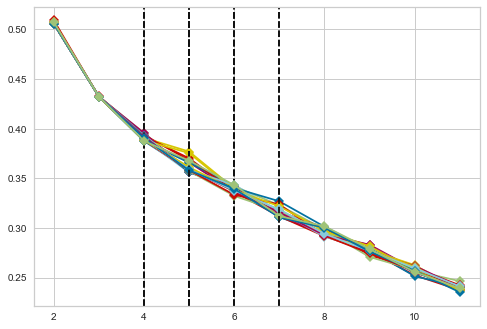

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
model = KElbowVisualizer(
    KMeans(), 
    k=(2,12), 
    metric='distortion', 
    timings=False, 
    locate_elbow=True
)

elbow_values = []
for i in range(0, 20):  
    model.fit(londen_grouped.drop('borough', 1))        # Fit the data to the visualizer
    if model.elbow_value_:
        elbow_values.append(model.elbow_value_)


In [31]:
print(np.array(elbow_values).mean())
print(elbow_values)

5.2631578947368425
[5, 5, 4, 6, 6, 5, 7, 4, 6, 5, 6, 5, 5, 5, 5, 4, 5, 5, 7]


#### From above, we select k = 5

In [32]:
# run k-means clustering
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(londen_grouped.drop('borough', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 2, 3, 2, 4, 4, 4, 2, 2, 1, 1, 0, 0, 0, 3, 1, 3, 3, 0, 4, 0,
       0, 0, 1, 4, 3, 0, 4, 1, 4, 0, 2])

In [33]:
londen_grouped.head()

,borough,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,BARKING AND DAGENHAM,0.0000,0.0000,0.0000,0.0000,0.0233,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,BARNET,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,BEXLEY,0.0000,0.0000,0.0000,0.0000,0.0179,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,BRENT,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,BROMLEY,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


#### Join data

In [34]:
neighborhoods_venues_sorted.insert(0, 'cluster', kmeans.labels_)

In [35]:
df_londen_result = df_combined.join(neighborhoods_venues_sorted.set_index('borough'), on='borough')
df_londen_result.head()

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BARKING AND DAGENHAM,51.5607,0.1557,309000.0000,3039,1,Grocery Store,Coffee Shop,Supermarket,Park,Pub,Fast Food Restaurant,Shopping Mall,Clothing Store,Furniture / Home Store,Café
1,BARNET,51.6252,-0.1517,500000.0000,3291,0,Café,Pub,Coffee Shop,Park,Turkish Restaurant,Italian Restaurant,Supermarket,Grocery Store,Greek Restaurant,Portuguese Restaurant
2,BEXLEY,51.4549,0.1505,348620.0000,4513,2,Pub,Grocery Store,Supermarket,Italian Restaurant,Furniture / Home Store,Park,Coffee Shop,Clothing Store,Steakhouse,Gas Station
3,BRENT,51.5588,-0.2817,470000.0000,3089,3,Coffee Shop,Indian Restaurant,Sandwich Place,Hotel,Clothing Store,Gym / Fitness Center,Grocery Store,Sporting Goods Shop,Pizza Place,Bar
4,BROMLEY,51.4039,0.0198,430000.0000,4055,2,Pub,Coffee Shop,Park,Gym / Fitness Center,Clothing Store,Grocery Store,Pizza Place,Indian Restaurant,Gastropub,Café


### Visualize data

In [36]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [37]:
london_map_result = folium.Map(
    location=[51.509865, -0.118092],
    zoom_start=11
)

# set color scheme for the clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']

for index, location in df_londen_result.iterrows():

    folium.CircleMarker(
        [location['latitude'], location['longitude']], 
        radius=8,
        popup=f"{location['borough']} cluster {location['cluster']}", 
        color=colors[location['cluster']],
        fill=True,
        fill_color=colors[location['cluster']],
        fill_opacity=0.7

    ).add_to(london_map_result)

london_map_result

### Exam clusters and Conclustions

Show the cluster, and try to find some common points. sort the data with price value so we can prioritize inside the cluster

#### Cluster 0

This looks like areas have night lives because of those pubs, Cafe, and coffee shops.

If you want to open a restaurant, go to HAMMERSMITH AND FULHAM, and try to avoid pizza, French restaurant, Japanese restaurant and Turkish restaurant.


In [38]:
df_londen_result[df_londen_result['cluster']==0].sort_values(by=['price'], ascending=False)

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,HAMMERSMITH AND FULHAM,51.4927,-0.2339,740000.0000,2263,0,Pub,Café,Coffee Shop,Gastropub,Pizza Place,Park,French Restaurant,Hotel,Japanese Restaurant,Turkish Restaurant
25,RICHMOND UPON THAMES,51.4479,-0.3260,623945.0000,2682,0,Pub,Café,Coffee Shop,Park,Rugby Stadium,Italian Restaurant,Garden,Hotel,Restaurant,Gastropub
17,ISLINGTON,51.5416,-0.1022,587000.0000,1400,0,Pub,Coffee Shop,Bakery,Gastropub,Cocktail Bar,Park,Café,Mediterranean Restaurant,Pizza Place,Japanese Restaurant
10,HACKNEY,51.5450,-0.0553,557087.5000,2062,0,Pub,Coffee Shop,Bakery,Café,Brewery,Bookstore,Pizza Place,Yoga Studio,Wine Bar,Vegetarian / Vegan Restaurant
20,LAMBETH,51.4607,-0.1163,520000.0000,2484,0,Pub,Coffee Shop,Market,Café,Restaurant,Brewery,Japanese Restaurant,Pizza Place,Park,Caribbean Restaurant
1,BARNET,51.6252,-0.1517,500000.0000,3291,0,Café,Pub,Coffee Shop,Park,Turkish Restaurant,Italian Restaurant,Supermarket,Grocery Store,Greek Restaurant,Portuguese Restaurant
12,HARINGEY,51.6000,-0.1119,500000.0000,2807,0,Café,Turkish Restaurant,Pub,Coffee Shop,Park,Bakery,Greek Restaurant,Mediterranean Restaurant,Gym / Fitness Center,Performing Arts Venue
19,KINGSTON UPON THAMES,51.4085,-0.3064,480000.0000,3472,0,Pub,Café,Garden,Park,Hotel,Gastropub,Coffee Shop,Gym / Fitness Center,Burger Joint,Portuguese Restaurant
29,WALTHAM FOREST,51.5908,-0.0134,440000.0000,3298,0,Pub,Café,Coffee Shop,Pizza Place,Park,Restaurant,Turkish Restaurant,Brewery,Mediterranean Restaurant,Supermarket
21,LEWISHAM,51.4452,-0.0209,409995.0000,3253,0,Pub,Park,Café,Coffee Shop,Gastropub,Italian Restaurant,Indian Restaurant,Gym / Fitness Center,Turkish Restaurant,Farmers Market


#### Cluster 1

This looks like areas for livings because of the supermarkets and grocery stores. With convenient transportations the difference in average house price are not so big.

If you want to open a restaurant, try to go to MERTON, and try to avoid Sushi, Indian, and Italian restaurants.


In [39]:
df_londen_result[df_londen_result['cluster']==1].sort_values(by=['price'], ascending=False)

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,MERTON,51.4014,-0.1958,464100.0000,3028,1,Park,Supermarket,Pub,Sushi Restaurant,Tram Station,Indian Restaurant,Grocery Store,Italian Restaurant,Café,Theater
9,GREENWICH,51.4892,0.0648,430000.0000,2483,1,Pub,Park,Grocery Store,Hotel,Gym / Fitness Center,Café,Coffee Shop,Bakery,Fast Food Restaurant,Clothing Store
8,ENFIELD,51.6538,-0.0799,385550.0000,3445,1,Supermarket,Pub,Turkish Restaurant,Coffee Shop,Grocery Store,Train Station,Gym / Fitness Center,Park,Pizza Place,Bar
27,SUTTON,51.3618,-0.1945,380000.0000,3432,1,Pub,Grocery Store,Supermarket,Coffee Shop,Park,Hotel,Italian Restaurant,Gym / Fitness Center,Pizza Place,Train Station
14,HAVERING,51.5812,0.1837,360000.0000,3918,1,Grocery Store,Coffee Shop,Supermarket,Pub,Fast Food Restaurant,Bakery,Italian Restaurant,Park,Café,Pizza Place
0,BARKING AND DAGENHAM,51.5607,0.1557,309000.0000,3039,1,Grocery Store,Coffee Shop,Supermarket,Park,Pub,Fast Food Restaurant,Shopping Mall,Clothing Store,Furniture / Home Store,Café


#### Cluster 2

Looks like places mixed with nature and inhabitants.

Open a restaurant in WANDSWORTH, and avoid pizza, burger, French and Thai restaurant.


In [40]:
df_londen_result[df_londen_result['cluster']==2].sort_values(by=['price'], ascending=False)

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,WANDSWORTH,51.4567,-0.1910,610000.0000,2541,2,Coffee Shop,Pub,Park,Pizza Place,Café,Supermarket,Bakery,French Restaurant,Burger Joint,Thai Restaurant
7,EALING,51.5130,-0.3089,460000.0000,2839,2,Park,Pub,Coffee Shop,Grocery Store,Hotel,Café,Burger Joint,Pizza Place,Italian Restaurant,Brewery
4,BROMLEY,51.4039,0.0198,430000.0000,4055,2,Pub,Coffee Shop,Park,Gym / Fitness Center,Clothing Store,Grocery Store,Pizza Place,Indian Restaurant,Gastropub,Café
6,CROYDON,51.3714,-0.0977,372500.0000,3894,2,Coffee Shop,Pub,Grocery Store,Pizza Place,Café,Park,Indian Restaurant,Bookstore,Supermarket,Gym / Fitness Center
2,BEXLEY,51.4549,0.1505,348620.0000,4513,2,Pub,Grocery Store,Supermarket,Italian Restaurant,Furniture / Home Store,Park,Coffee Shop,Clothing Store,Steakhouse,Gas Station


#### Cluster 3

Those areas have lots of Indian restaurant. The house price is quite average here. 

Go to BRENT for slightly higher price. Avoid open another Indian restaurant in those areas.


In [41]:
df_londen_result[df_londen_result['cluster']==3].sort_values(by=['price'], ascending=False)

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,BRENT,51.5588,-0.2817,470000.0000,3089,3,Coffee Shop,Indian Restaurant,Sandwich Place,Hotel,Clothing Store,Gym / Fitness Center,Grocery Store,Sporting Goods Shop,Pizza Place,Bar
13,HARROW,51.5898,-0.3346,454500.0000,4134,3,Indian Restaurant,Coffee Shop,Pub,Gym / Fitness Center,Supermarket,Café,Park,Italian Restaurant,Gastropub,Portuguese Restaurant
24,REDBRIDGE,51.5590,0.0741,415000.0000,3116,3,Indian Restaurant,Park,Supermarket,Fast Food Restaurant,Clothing Store,Coffee Shop,Portuguese Restaurant,Sandwich Place,Hotel,Bakery
15,HILLINGDON,51.5441,-0.4760,407000.0000,5652,3,Pub,Indian Restaurant,Coffee Shop,Supermarket,Gym / Fitness Center,Golf Course,Park,Bar,Hotel,Restaurant
16,HOUNSLOW,51.4746,-0.3680,400000.0000,3099,3,Pub,Coffee Shop,Indian Restaurant,Clothing Store,Grocery Store,Hotel,Bakery,Supermarket,Fast Food Restaurant,Sandwich Place


#### Cluster 4

Areas with highest house price, has lots of hotels and coffee shop, looks places for tourism and business.

Go to KENSINGTON AND CHELSEA if possible and avoid to open a Italian and Indian restaurant.


In [42]:
df_londen_result[df_londen_result['cluster']==4].sort_values(by=['price'], ascending=False)

,borough,latitude,longitude,price,radius,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,KENSINGTON AND CHELSEA,51.5020,-0.1947,1270000.0000,1997,4,Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Bakery,Indian Restaurant,Pub,Clothing Store,Café,Burger Joint
31,CITY OF WESTMINSTER,51.4973,-0.1372,970000.0000,1891,4,Hotel,Theater,Plaza,Art Museum,Garden,Cocktail Bar,Japanese Restaurant,Indian Restaurant,Park,Café
32,CITY OF LONDON,51.5155,-0.0922,923080.0000,1218,4,Gym / Fitness Center,Coffee Shop,Hotel,Steakhouse,Garden,Cocktail Bar,Vietnamese Restaurant,Salad Place,Seafood Restaurant,Indie Movie Theater
5,CAMDEN,51.5290,-0.1255,770000.0000,1419,4,Coffee Shop,Café,Hotel,Pizza Place,Bookstore,History Museum,Beer Bar,Burger Joint,Breakfast Spot,Art Gallery
26,SOUTHWARK,51.5035,-0.0804,550000.0000,1632,4,Coffee Shop,Hotel,Cocktail Bar,Italian Restaurant,Bakery,Garden,Scenic Lookout,Restaurant,Beer Bar,Tapas Restaurant
28,TOWER HAMLETS,51.5099,-0.0059,475000.0000,2348,4,Coffee Shop,Hotel,Burger Joint,Gym / Fitness Center,Pub,Bar,Park,Plaza,Scenic Lookout,Italian Restaurant
23,NEWHAM,51.5077,0.0469,402500.0000,2014,4,Hotel,Coffee Shop,Café,Gym / Fitness Center,Sandwich Place,Pub,Supermarket,Grocery Store,Convenience Store,Light Rail Station


## Problems
- Price not contains size information, leads to inaccuracy
- London is very big, Top 100 venues might not represent a full view of a area 